# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
!pip install torch torchvision

In [2]:
!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2023-02-20 18:39:21--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Распознаётся ufldl.stanford.edu (ufldl.stanford.edu)… 171.64.68.10
Подключение к ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 182040794 (174M) [text/plain]
Сохранение в: «train_32x32.mat»

train_32x32.mat     100%[===================>] 173,61M  2,41MB/s    за 4m 44s  

2023-02-20 18:44:05 (627 KB/s) - «train_32x32.mat» сохранён [182040794/182040794]

--2023-02-20 18:44:05--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Повторное использование соединения с ufldl.stanford.edu:80.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 64275384 (61M) [text/plain]
Сохранение в: «test_32x32.mat»

test_32x32.mat      100%[===================>]  61,30M   800KB/s    за 85s     

2023-02-20 18:45:31 (737 KB/s) - «test_32x32.mat» сохранён [64275384/64275384]

ЗАВЕРШЕНО --2023-02-20 18:45:31--
Общее время: 6m 10s
Загруж

In [11]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [4]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [5]:
#!g1.1
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [6]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [7]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [8]:
#!g1.1
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [9]:
#!g1.1
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Implement the inference of the model on all of the batches from loader,
    #       and compute the overall accuracy.
    # Hint: PyTorch has the argmax function!
    correct_samples = 0
    total_samples = 0
    for i_step, (x, y) in enumerate(loader):
        x_gpu = x.to(device)
        y_gpu = y.to(device)
        prediction = model(x_gpu)    
        _, indices = torch.max(prediction, 1)
        correct_samples += torch.sum(indices == y_gpu)
        total_samples += y.shape[0]
    accuracy = float(correct_samples) / total_samples
    return accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.456528, Train accuracy: 0.508224, Val accuracy: 0.741315
Average loss: 0.726194, Train accuracy: 0.778965, Val accuracy: 0.784520
Average loss: 0.600988, Train accuracy: 0.819831, Val accuracy: 0.827930
Average loss: 0.551137, Train accuracy: 0.835358, Val accuracy: 0.821241
Average loss: 0.517445, Train accuracy: 0.846671, Val accuracy: 0.845130


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [14]:
#!g1.1
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/home/agat.local/s.bulganin/.local/lib/python3.9/site-packages/torchvision/transforms/transforms.py:1303: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

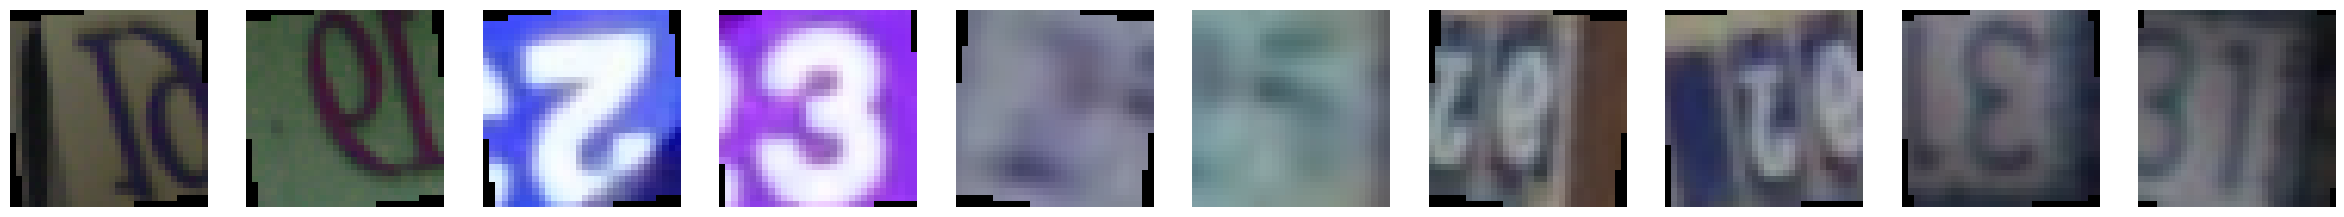

In [16]:
#!g1.1
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, interpolation=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [17]:
#!g1.1
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                               sampler=train_sampler)

In [18]:
#!g1.1
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 20)

Average loss: 0.496502, Train accuracy: 0.853036, Val accuracy: 0.840352
Average loss: 0.475527, Train accuracy: 0.857608, Val accuracy: 0.828339
Average loss: 0.454757, Train accuracy: 0.863069, Val accuracy: 0.839533
Average loss: 0.449276, Train accuracy: 0.864877, Val accuracy: 0.857484
Average loss: 0.434027, Train accuracy: 0.869245, Val accuracy: 0.853798
Average loss: 0.423756, Train accuracy: 0.873494, Val accuracy: 0.836803
Average loss: 0.416965, Train accuracy: 0.873870, Val accuracy: 0.856187
Average loss: 0.405399, Train accuracy: 0.878852, Val accuracy: 0.856597
Average loss: 0.396256, Train accuracy: 0.880917, Val accuracy: 0.871476
Average loss: 0.391777, Train accuracy: 0.882845, Val accuracy: 0.866084
Average loss: 0.382119, Train accuracy: 0.885507, Val accuracy: 0.867722
Average loss: 0.378713, Train accuracy: 0.887093, Val accuracy: 0.869360
Average loss: 0.372034, Train accuracy: 0.888527, Val accuracy: 0.864105
Average loss: 0.363235, Train accuracy: 0.890591, V

# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [19]:
#!g1.1
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, stride=2),   
    nn.Conv2d(16, 120, 5),
    nn.ReLU(inplace=True),
    Flattener(),
    nn.Linear(120, 84),
    nn.ReLU(inplace=True),
    nn.Linear(84, 10)
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [20]:
#!g1.1
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 20)

Average loss: 1.316673, Train accuracy: 0.557093, Val accuracy: 0.805611
Average loss: 0.509346, Train accuracy: 0.852046, Val accuracy: 0.854208
Average loss: 0.410689, Train accuracy: 0.879790, Val accuracy: 0.882465
Average loss: 0.355371, Train accuracy: 0.896017, Val accuracy: 0.886219
Average loss: 0.313552, Train accuracy: 0.907091, Val accuracy: 0.878097
Average loss: 0.285830, Train accuracy: 0.914121, Val accuracy: 0.886151
Average loss: 0.258872, Train accuracy: 0.923250, Val accuracy: 0.894956
Average loss: 0.235061, Train accuracy: 0.929546, Val accuracy: 0.866152
Average loss: 0.221143, Train accuracy: 0.932703, Val accuracy: 0.894819
Average loss: 0.207586, Train accuracy: 0.937037, Val accuracy: 0.894205
Average loss: 0.193573, Train accuracy: 0.940245, Val accuracy: 0.889496
Average loss: 0.186062, Train accuracy: 0.942480, Val accuracy: 0.893318
Average loss: 0.168697, Train accuracy: 0.946763, Val accuracy: 0.889154
Average loss: 0.168188, Train accuracy: 0.946319, V

# Подбор гиперпараметров

In [21]:
#!g1.1
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size):   
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        scheduler.step()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [22]:
#!g1.1
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!

import random
params_grid = [learning_rates, anneal_epochs, reg]

n_results = 10
for i in range(n_results):
    params = [random.sample(param, 1)[0] for param in params_grid]
    print(f"lr={params[0]}, anneal_epochs={params[1]}, reg={params[2]}")
    
    optimizer = optim.SGD(lenet_model.parameters(), lr=params[0], weight_decay=params[2])
    _, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, 
                                                loss, optimizer, epoch_num, params[1])
    run_record[Hyperparams(*params)] = RunResult(lenet_model, train_history, 
                                                 val_history, val_history[-1])

lr=0.001, anneal_epochs=50, reg=1e-07


/home/agat.local/s.bulganin/.local/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Average loss: 0.093093, Train accuracy: 0.969474, Val accuracy: 0.899802
Average loss: 0.071635, Train accuracy: 0.977408, Val accuracy: 0.901577
Average loss: 0.065481, Train accuracy: 0.980156, Val accuracy: 0.902327
Average loss: 0.061394, Train accuracy: 0.981913, Val accuracy: 0.902464
Average loss: 0.058359, Train accuracy: 0.982869, Val accuracy: 0.903283
Average loss: 0.055995, Train accuracy: 0.983739, Val accuracy: 0.903761
Average loss: 0.054000, Train accuracy: 0.984541, Val accuracy: 0.904512
Average loss: 0.052351, Train accuracy: 0.985104, Val accuracy: 0.904921
Average loss: 0.050867, Train accuracy: 0.985667, Val accuracy: 0.905194
Average loss: 0.049580, Train accuracy: 0.986367, Val accuracy: 0.905399
lr=0.0001, anneal_epochs=20, reg=1e-07
Average loss: 0.048460, Train accuracy: 0.986725, Val accuracy: 0.905331
Average loss: 0.048354, Train accuracy: 0.986725, Val accuracy: 0.905262
Average loss: 0.048227, Train accuracy: 0.986810, Val accuracy: 0.905331
Average loss

In [23]:
#!g1.1
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.91, best hyperparams: Hyperparams(learning_rate=0.0001, anneal_epochs=20, reg=1e-07)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [43]:
#!g1.1
best_model = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.Dropout(0.25),
    nn.Conv2d(32, 128, 3, stride=2, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.25),
    nn.Conv2d(128, 256, 5, stride=2),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.25),
    nn.Conv2d(256, 256, 5, stride=2, padding=2),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.25),
    nn.Conv2d(256, 256, 5, stride=2, padding=2),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    Flattener(),
    nn.Linear(1024, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 10)
)

for module in best_model.parameters():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))

    
best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.RMSprop(best_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 20, 1)


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Average loss: 0.703309, Train accuracy: 0.782992, Val accuracy: 0.882192
Average loss: 0.326297, Train accuracy: 0.901153, Val accuracy: 0.915637
Average loss: 0.247466, Train accuracy: 0.925724, Val accuracy: 0.926626
Average loss: 0.206473, Train accuracy: 0.939170, Val accuracy: 0.930926
Average loss: 0.178806, Train accuracy: 0.948367, Val accuracy: 0.934817
Average loss: 0.167404, Train accuracy: 0.951421, Val accuracy: 0.934407
Average loss: 0.161589, Train accuracy: 0.953179, Val accuracy: 0.934202
Average loss: 0.157355, Train accuracy: 0.955124, Val accuracy: 0.934612
Average loss: 0.159279, Train accuracy: 0.954749, Val accuracy: 0.935431
Average loss: 0.156535, Train accuracy: 0.954715, Val accuracy: 0.935158
Average loss: 0.154050, Train accuracy: 0.955790, Val accuracy: 0.935022
Average loss: 0.153760, Train accuracy: 0.956370, Val accuracy: 0.934817
Average loss: 0.154715, Train accuracy: 0.955841, Val accuracy: 0.935363
Average loss: 0.156259, Train accuracy: 0.955670, V

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [44]:
#!g1.1
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9295866625691457


In [28]:
#!g1.1


In [29]:
#!g1.1


In [ ]:
#!g1.1
